In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import

In [2]:
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, os
from tqdm import tqdm

In [3]:
raw_dir = Path("raw")

raws = [raw_path for raw_path in raw_dir.ls() if ".tif" in raw_path.as_posix()]

#labelled by Mallar
images = sorted([raw_path for raw_path in raws if re.match(r"[\d]{1,2}_image.tif", raw_path.name)])
labels = sorted([raw_path for raw_path in raws if re.match(r"[\d]{1,2}_label.tif", raw_path.name)])

In [4]:
all_contours = []
for label_path in tqdm(labels[:]):
    
    image = cv.imread(label_path.as_posix(), cv.COLOR_BGR2GRAY)
    
#     plt.figure(figsize = (10,10))
#     plt.imshow(image); plt.show()

    contours, hierarchy = cv.findContours(
        image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    all_contours.extend([np.squeeze(contour,axis=1) for contour in contours])

100%|██████████| 46/46 [00:00<00:00, 63.19it/s]


In [5]:
df = pd.DataFrame(
    {'contour': all_contours}
).assign(
    moments = lambda df: df.contour.apply(lambda contour: cv.moments(contour)),
    area = lambda df: df.contour.apply(lambda contour: cv.contourArea(contour)),
    perimeter = lambda df: df.contour.apply(lambda contour: cv.arcLength(contour, closed=True)),
    ellipse = lambda df: df.contour.apply(lambda contour: cv.fitEllipse(contour))
).assign(
    #center, axes_lengths, orientation
    major_axis_length = lambda df: df.ellipse.apply(lambda ellipse: max(ellipse[1])),
    minor_axis_length = lambda df: df.ellipse.apply(lambda ellipse: min(ellipse[1]))
).assign(
    eccentricity = lambda df: np.sqrt(1 - (df.minor_axis_length / df.major_axis_length) ** 2 ) 
)

In [6]:
dist = cv.pointPolygonTest(contour = df.contour[0], pt = (738,90), measureDist = False)
dist

1.0

In [7]:
df.head(2)

,contour,moments,area,perimeter,ellipse,major_axis_length,minor_axis_length,eccentricity
0,"[[735, 84], [734, 85], [733, 86], [732, 87], [...","{'m00': 54.0, 'm10': 39813.666666666664, 'm01'...",54.0,28.142135,"((737.2798461914062, 87.33068084716797), (7.30...",9.828528,7.306267,0.668877
1,"[[885, 556], [884, 557], [884, 558], [884, 559...","{'m00': 73.5, 'm10': 65369.166666666664, 'm01'...",73.5,33.899495,"((889.365966796875, 559.8482055664062), (8.003...",12.118528,8.003853,0.750858



    Average: 91.94
    Standard Deviation: 30.07
    5th Percentile: 50.53
    95th Percentile: 147.78
    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feef192ed68>]],
      dtype=object)

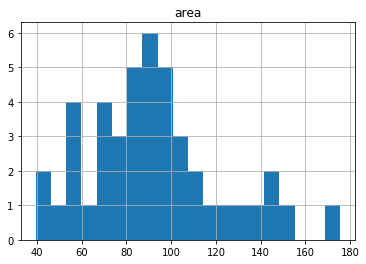

In [8]:
print(
    """
    Average: {:.2f}
    Standard Deviation: {:.2f}
    5th Percentile: {:.2f}
    95th Percentile: {:.2f}
    """.format(
        df["area"].mean(), df["area"].std(),
        df["area"].quantile(q=0.05), df["area"].quantile(q=0.95)
    )
)
df.hist("area", bins=20)


    Average: 0.69
    Standard Deviation: 0.13
    5th Percentile: 0.53
    95th Percentile: 0.84
    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feef055b400>]],
      dtype=object)

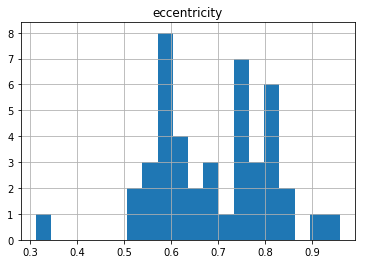

In [9]:
print(
    """
    Average: {:.2f}
    Standard Deviation: {:.2f}
    5th Percentile: {:.2f}
    95th Percentile: {:.2f}
    """.format(
        df["eccentricity"].mean(), df["eccentricity"].std(),
        df["eccentricity"].quantile(q=0.05), df["eccentricity"].quantile(q=0.95)
    )
)
df.hist("eccentricity", bins=20)

<img src="https://files.mtstatic.com/site_4539/7119/0?Expires=1566497982&Signature=hDIctTs7NKIlDdSo1aYdZdcIv3IX-moOh0OA3aZdq78iVorZK3~1mSHXtPOZNmtN4GSi8ilelyOsJ4AtK5hMDJ4oRAgbYXvrXQEF1JJcY~mTY8ZnqPTAqnHDzr~eS-78LWH~rLfJL554etA0woY~x8GM899PGb3pQyDmprEC7XQ_&Key-Pair-Id=APKAJ5Y6AV4GI7A555NA " width="300">